In [2]:
import csv
import collections
import numpy as np
import cvxpy as cp
import copy
import matplotlib.pyplot as plt

In [66]:
num_buses = 30
num_gen = 6
generators = np.array([0, 1, 12, 21, 22, 26]) # indexing so -1
cost_vec = np.array([100, 150, 240, 350, 500, 300], dtype=float) # cost of each generator
carbon_emission_rate_vec = np.array([2159, 2002, 1611, 890, 577, 113], dtype=float) # carbon emission of each generator co2/mhw
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
line_to_nodes = []
with open('30bus_topology.csv', 'r') as csvfile:
    #next(csvfile)
    for line in csvfile:
        l = list(map(lambda x: int(x)-1, line.split(','))) # turn "1,2" to [1,2]
        graph[l[0]].append((l[1], len(line_to_nodes)))
        graph_reverse[l[1]].append((l[0], len(line_to_nodes)))
        line_to_nodes.append(l)
num_lines = len(line_to_nodes)
load = np.random.uniform(1.5, 1.8, (num_buses, 1)) # load vector i.e. power demand at each bus/node
line_flow_limit = np.full((num_lines, 1), 4.0) # largest line flow rate is 4.0
neg_line_flow_limit = np.full((num_lines, 1), -4.0) # smallest is -4.0
power_generation_limit = np.full((num_gen, 1), 10.0) # upper limit is 15
neg_power_generation_limit = np.full((num_gen, 1), 0.0) # lower power generation limit is 0

In [67]:
def get_avg_carbon(load):
    graph_copy = copy.deepcopy(graph)
    graph_reverse_copy = copy.deepcopy(graph_reverse)
    power_generation = cp.Variable(shape=(num_gen, 1)) # shape [num_gen, 1]
    line_flow = cp.Variable(shape=(num_lines, 1)) # shape [num_line, 1]
    # condition 5(b)
    b = np.zeros((num_buses, num_gen), dtype=float) # a matrix to convert power_generation from [x1, x2, x3, x4, x5, x6] to [x1, x2, 0,0,0,0,0,0,0,0,0,x3, ...] of size 30*1
    # b @ power_generation = new_power_generation
    for i, v in enumerate(generators):
        b[v][i] = 1.0
    a = np.zeros((num_buses, num_lines), dtype=float) # this matrix uses ie. 1.0/-1.0 to represent inflow/outflow. 
    # for example, line 0 is [1,2], which means power flows from bus 1 to bus 2 at line flow rate x0 at line 0. 
    # We would -x0 at index 0 of new line flow and +x0 at index 1 of new line flow. 
    # So the new line flow of shape [num_bus, 1] means at each bus/node, what is the power flow (inflow-outflow at the node).
    for i, v in enumerate(line_to_nodes):
        a[v[0]][i] = 1.0
        a[v[1]][i] = -1.0

    prob = cp.Problem(cp.Minimize(cp.sum(cost_vec @ power_generation)), # eq 5(a)
                    [b @ power_generation - load == a @ line_flow, # eqation 5(b) meaning: at each node/bus the power generated at this bus(some bus are generator) + the power inflow(can be negative) == the power demand at the bus
                    line_flow <= line_flow_limit, # eq 5(c)
                    line_flow >= neg_line_flow_limit, # eq 5(c)
                    power_generation <= power_generation_limit, # eq 5(d)
                    power_generation >= neg_power_generation_limit]) # eq 5(d)
    prob.solve(solver=cp.CVXOPT)
    for i, f in enumerate(line_flow.value):
        if f < 0.0:
            from_node, to_node = line_to_nodes[i]
            graph_copy[from_node].remove((to_node, i))
            graph_copy[to_node].append((from_node, i))
            graph_reverse_copy[to_node].remove((from_node, i))
            graph_reverse_copy[from_node].append((to_node, i))
            line_flow.value[i] = -f
    line_to_gen = collections.defaultdict(set)
    node_to_gen = collections.defaultdict(set)
    def dfs(g, n, visited):
        if n in visited: return
        visited.add(n)
        node_to_gen[n].add(g)
        for nei, line in graph_copy[n]:
            line_to_gen[line].add(g)
            dfs(g, nei, visited)

    for i, g in enumerate(generators):
        visited = set()
        if power_generation.value[i] >= 0.0001:
            dfs(g, g, visited)
    line_prop_mat=np.zeros((num_gen, num_lines), dtype=float)
    bus_prop_mat=np.zeros((num_gen, num_buses), dtype=float)
    # initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
    for k, v in node_to_gen.items():
        if len(v) == 1:
            idx = list(generators).index(list(v)[0])
            bus_prop_mat[idx][k] = 1.0
    for k, v in line_to_gen.items():
        if len(v) == 1:
            idx = list(generators).index(list(v)[0])
            line_prop_mat[idx][k] = 1.0
    # visit nodes in topological order
    # step 1: calculate bus_prop based on in flowing lines_prop
    # step 2: calculate line_prop of out flowing lines
    in_degree = collections.defaultdict(int)
    for i, v in graph_reverse_copy.items():
        in_degree[i] = len(v)
    q = [] # list of nodes with no inflow
    topo_order = []
    for g in generators:
        if in_degree[g] == 0:
            q.append(g)
    while q:
        cur = q.pop(0)
        if len(node_to_gen[cur]) > 1:
            out_total = load[cur][0]
            for nei, out_line in graph_copy[cur]:
                out_total += line_flow.value[out_line]
            for g in node_to_gen[cur]:
                idx = list(generators).index(g)
                if cur == g:
                    bus_prop_mat[idx][cur] = power_generation.value[idx]/out_total
                else:
                    for nei, in_line in graph_reverse_copy[cur]:
                        bus_prop_mat[idx][cur] += line_flow.value[in_line]*line_prop_mat[idx][in_line]/out_total
            for g in node_to_gen[cur]:
                idx = list(generators).index(g)
                for nei, out_line in graph_copy[cur]:
                    line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

        topo_order.append(cur)
        for nei, line in graph_copy[cur]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)
    #avg_carbon_emission_rate_node = carbon_emission_rate_vec @ bus_prop_mat
    bus_prop_mat_prop = np.zeros((num_gen, num_buses), dtype=float)
    for i in range(num_gen):
        s = np.sum(bus_prop_mat[i])
        for j in range(num_buses):
            if s != 0.0:
                bus_prop_mat_prop[i][j] = bus_prop_mat[i][j]/s
    carbon_vec = np.zeros((num_buses, 1), dtype=float)
    for i in range(num_buses):
        for j in range(num_gen):
            #load[i] += bus_prop_mat[j,i] * power_generation.value[j]
            carbon_vec[i] += bus_prop_mat_prop[j,i] * power_generation.value[j] * carbon_emission_rate_vec[j]
    total_cost = np.dot(cost_vec, power_generation.value)
    #print(np.round(bus_prop_mat_prop, 2))
    return carbon_vec, total_cost, power_generation.value

In [68]:
marginal_rate_vec_all=np.zeros((5, num_buses), dtype=float)
power_gen_all = np.zeros((5, num_gen, num_buses), dtype=bool)
total_carbon = []
total_cost = []
percent = 0.2
for k in range(5):
    load *= percent
    carbon_vec_old, total_cost_num, power_gen_old = get_avg_carbon(load)
    margin_carbon_emission = np.zeros((num_buses, 1), dtype=float)
    total_carbon.append(sum(carbon_vec_old))
    total_cost.append(total_cost_num)
    for m, v in enumerate(load):
        epsi = 0.01*v
        load[m] += epsi
        carbon_vec_after, _, power_gen_after = get_avg_carbon(load)
        margin_carbon_emission = (carbon_vec_after - carbon_vec_old)/epsi
        power_gen_all[k, :, m] = np.reshape(power_gen_after - power_gen_old > 0.0, (num_gen, ))
        marginal_rate_vec_all[k, m] = margin_carbon_emission[m]
        load[m] -= epsi
    load /= percent
    percent += 0.2

C:\Users\syq41\AppData\Local\Temp\ipykernel_25644\1254637359.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bus_prop_mat[idx][cur] += line_flow.value[in_line]*line_prop_mat[idx][in_line]/out_total
C:\Users\syq41\AppData\Local\Temp\ipykernel_25644\1254637359.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bus_prop_mat[idx][cur] = power_generation.value[idx]/out_total
C:\Users\syq41\AppData\Local\Temp\ipykernel_25644\2867865598.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (D

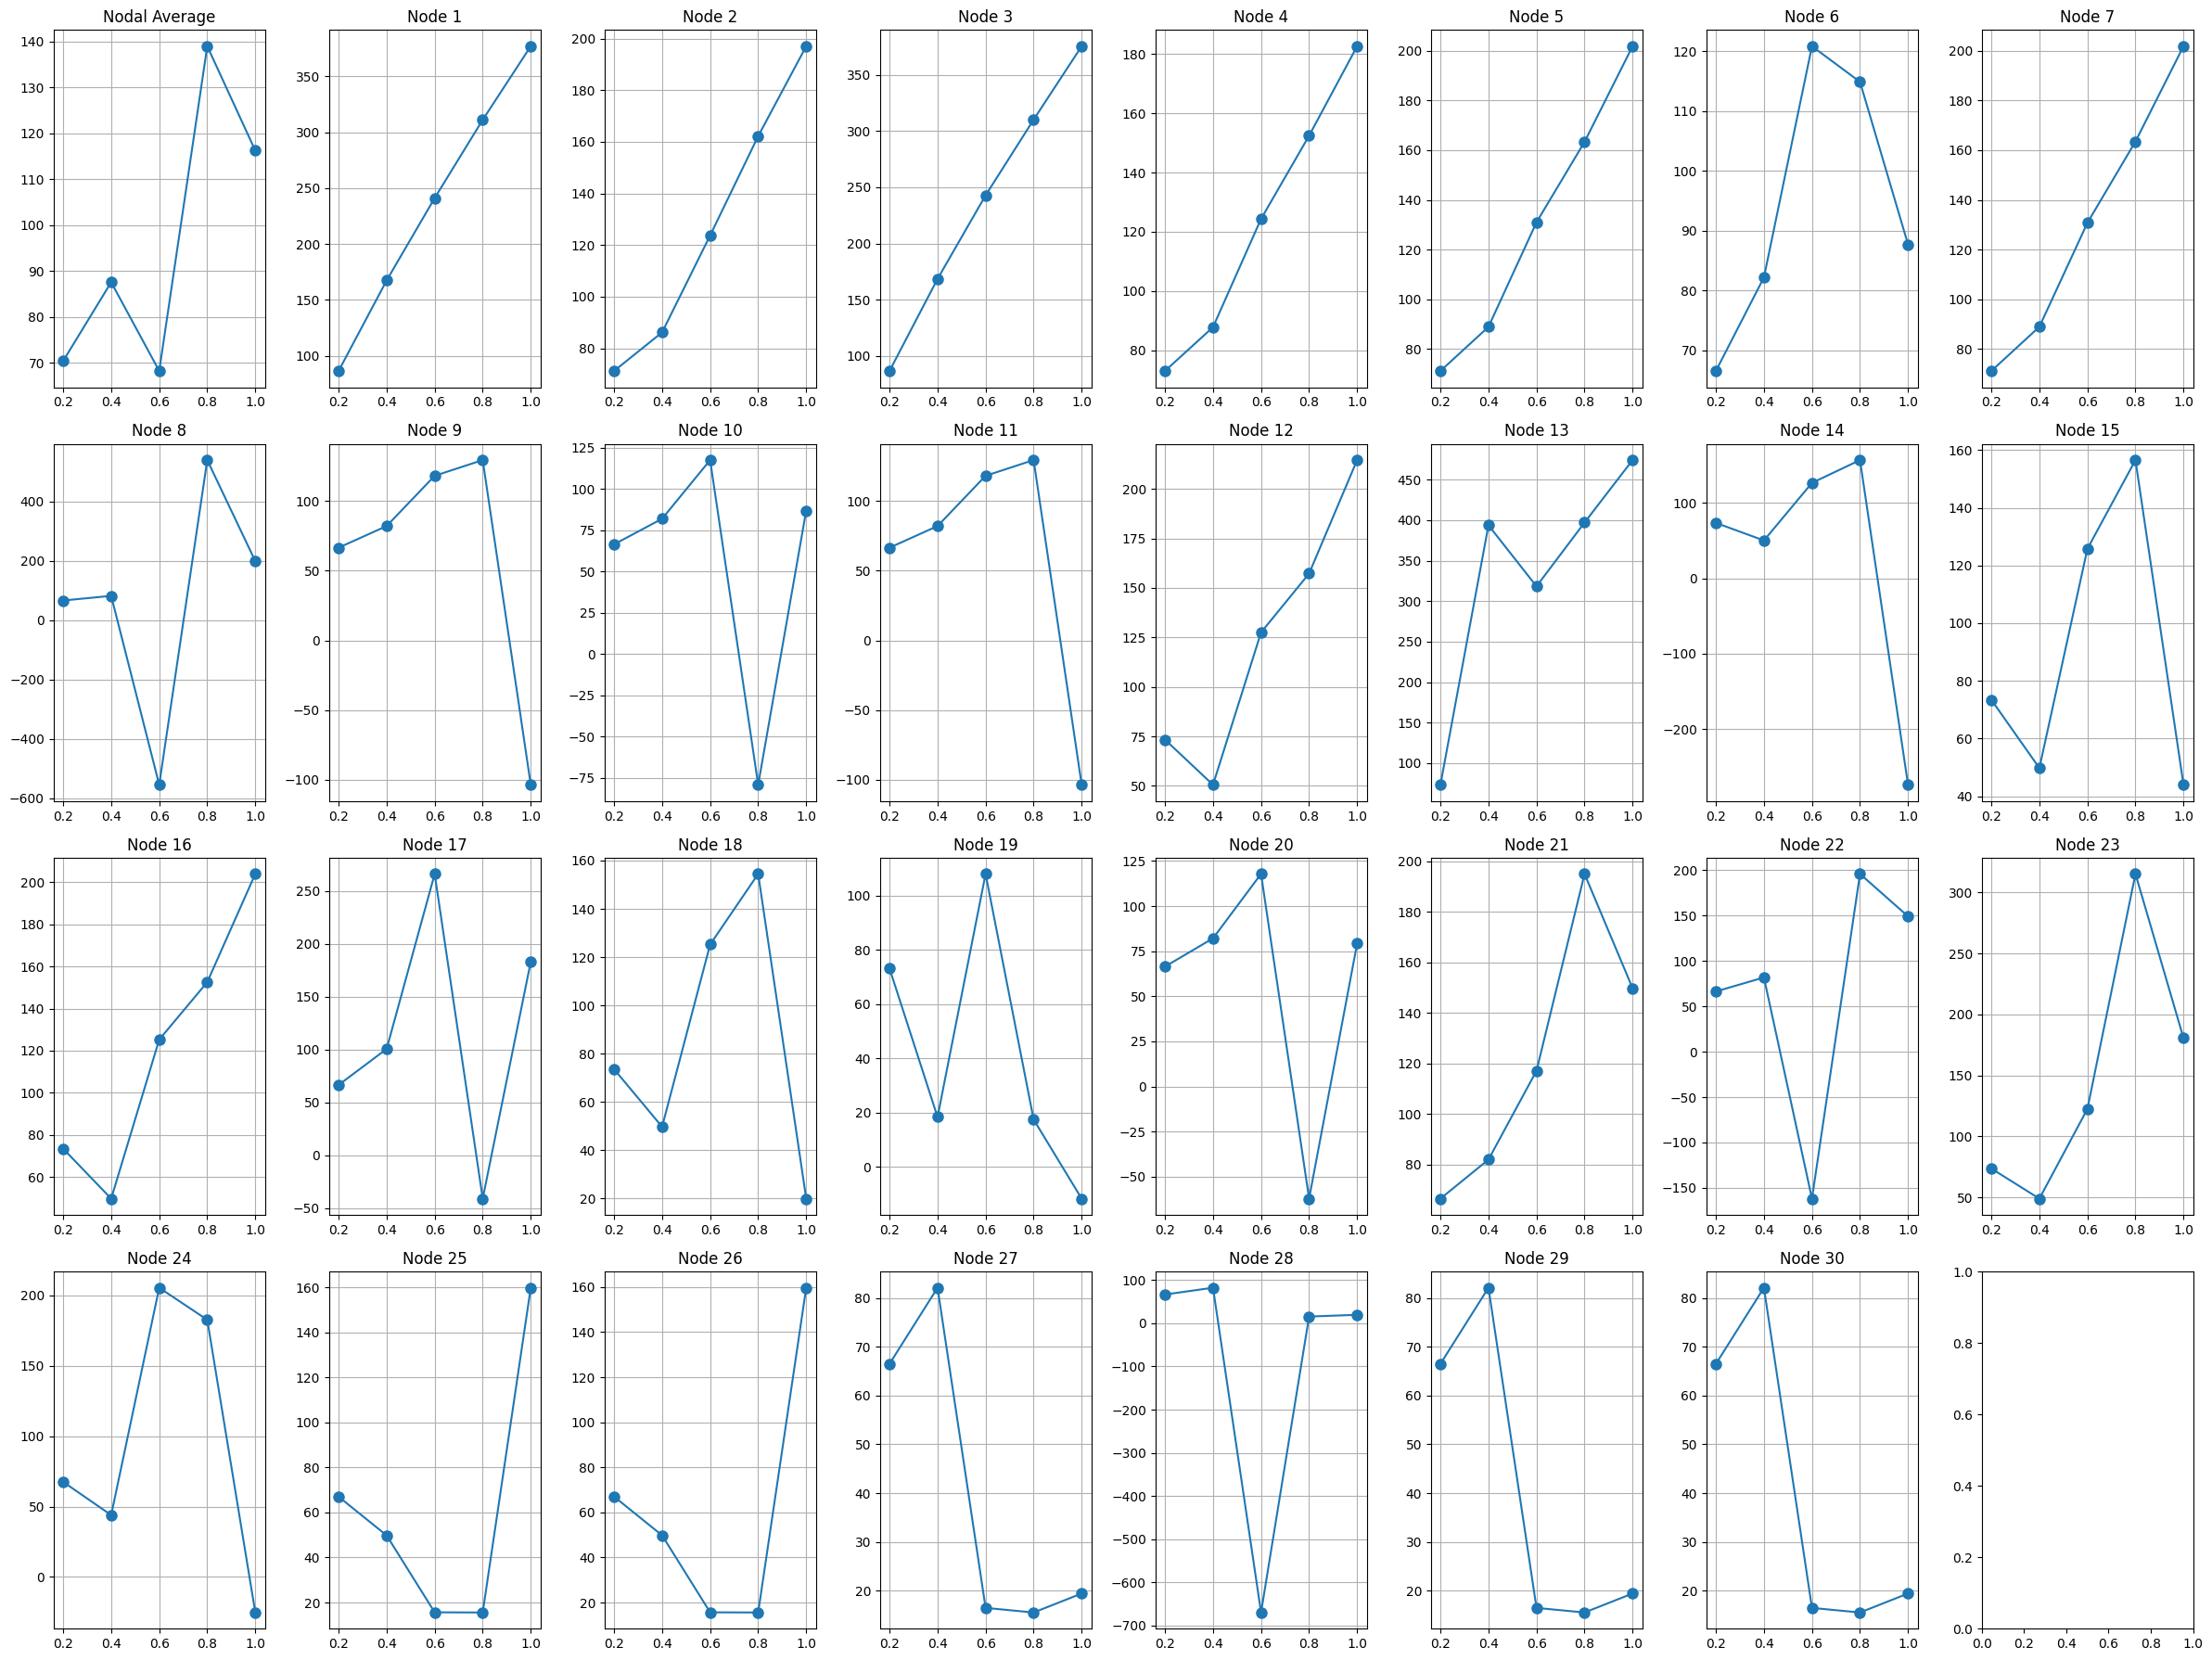

In [69]:
y = np.average(marginal_rate_vec_all, axis=1)
x = [0.2,0.4,0.6,0.8,1.0]
fig, axis =  plt.subplots(4, 8)
fig.set_figwidth(24)
fig.set_figheight(18)
axis[0][0].plot(x, y, marker='o', markersize=8)
axis[0][0].grid()
axis[0][0].set_title("Nodal Average")
for i in range(4):
    for j in range(8):
        if i == 0 and j == 0 or (i*8+j-1 >= 30): continue
        axis[i][j].plot(x, marginal_rate_vec_all[:, i*8+j-1], marker='o', markersize=8)
        axis[i][j].set_title("Node " + str(i*8+j))
        axis[i][j].grid()
fig.tight_layout()

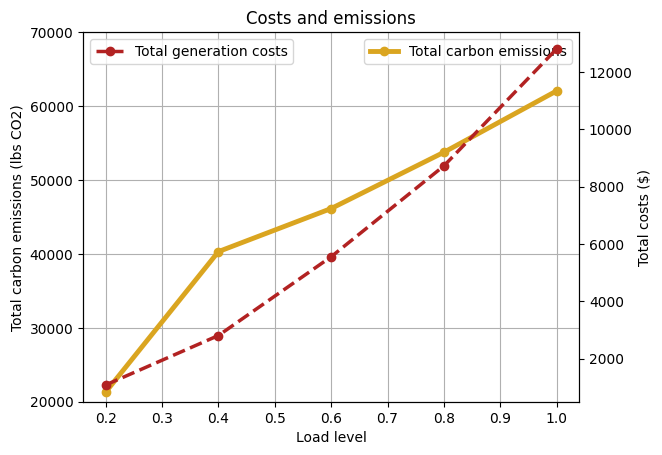

In [70]:
x=[0.2, 0.4, 0.6, 0.8, 1.0]
fig, ax1 = plt.subplots()
ax1.plot(x,total_carbon, linewidth=3.5, color='goldenrod',linestyle='-', marker='o', label='Total carbon emissions')
ax1.set_ylabel('Total carbon emissions (lbs CO2)')
ax1.set_ylim([20000, 70000])
ax2=ax1.twinx()
ax2.plot(x,total_cost, linewidth=2.5, color='firebrick',linestyle='--', marker='o', label='Total generation costs')
ax1.set_xlabel('Load level')
ax1.set_title('Costs and emissions')
ax2.set_ylabel('Total costs ($)')
ax1.grid()
ax1.legend()
ax2.legend()
plt.show()